# Getting started with prenspire

In [1]:
import random
from pathlib import Path
from clophfit.prenspire import prenspire

%load_ext autoreload
%autoreload 2
tpath = Path("../../tests/EnSpire")

In [2]:
efx1 = prenspire.EnspireFile(tpath / "h148g-spettroC.csv")
efx2 = prenspire.EnspireFile(tpath / "e2dan-with_sample_column.csv")
efx3 = prenspire.EnspireFile(tpath / "S202N-E2_pHs.csv")

In [3]:
efx3.metadata

{'Measurement date': '2013-06-14 23:13:51',
 'Chamber temperature at start': '19.55',
 'Chamber temperature at end': '36.5',
 'Ambient temperature at start': '4.7',
 'Ambient temperature at end': '8.4',
 'Protocol name': 'All Spectra (A+B+C+D+E)',
 'Exported data': 'Well,Sample,MeasA:Result,MeasB:Result,MeasC:Result,MeasA:Wavelength,MeasB:Wavelength,MeasC:Wavelength,MeasD:Wavelength,MeasD:Result,MeasE:Wavelength,MeasE:Result,MeasF:Wavelength,MeasF:Result,MeasG:Wavelength,MeasG:Result,MeasH:Wavelength,MeasH:Result,MeasI:Wavelength,MeasI:Result',
 'warnings': ['WARNING: 14.06.2013 15:55:11: Temperature stabilized to 24.45 °C. Target temperature 25.00 °C. Continuing measurement.',
  'WARNING: 14.06.2013 19:44:41: Temperature stabilized to 36.30 °C. Target temperature 37.00 °C. Continuing measurement.']}

In [4]:
efx1.__dict__.keys()

dict_keys(['_ini', '_fin', '_data_list', '_metadata_post', '_well_list_platemap', '_platemap', 'metadata', '_filename'])

In [5]:
efx1.extract_measurements()
efx1.__dict__.keys()

dict_keys(['_ini', '_fin', '_data_list', '_metadata_post', '_well_list_platemap', '_platemap', 'metadata', '_filename', 'measurements', 'wells', 'samples'])

In [6]:
efx2.extract_measurements()
efx3.extract_measurements()

efx2.wells[:4], efx3.samples[:4]

(['F01', 'F02', 'F03', 'F04'], ['UNK1', 'UNK2', 'UNK3', 'UNK4'])

In [7]:
efx1.measurements.keys(), efx3.measurements.keys()

(dict_keys(['A']), dict_keys(['D', 'A', 'B', 'C', 'E', 'F', 'G', 'H', 'I']))

when testing each spectra for the presence of a single wavelength in the appropriate monochromator

In [8]:
efx2.measurements["A"]["metadata"]

{'temp': '25',
 'Monochromator': 'Excitation',
 'Min wavelength': '400',
 'Max wavelength': '510',
 'Wavelength': '530',
 'Using of excitation filter': 'Top',
 'Measurement height': '8.9',
 'Number of flashes': '50',
 'Number of flashes integrated': '50',
 'Flash power': '100'}

In [9]:
efx2._data_list[0]

['Well',
 'Sample',
 'MeasB:WavelengthExc',
 'MeasB:WavelengthEms',
 'MeasB:Result',
 'MeasA:WavelengthExc',
 'MeasA:WavelengthEms',
 'MeasA:Result',
 'MeasC:WavelengthExc',
 'MeasC:WavelengthEms',
 'MeasC:Result',
 'MeasD:WavelengthExc',
 'MeasD:WavelengthEms',
 'MeasD:Result',
 'MeasE:WavelengthExc',
 'MeasE:WavelengthEms',
 'MeasE:Result',
 'MeasF:WavelengthExc',
 'MeasF:WavelengthEms',
 'MeasF:Result',
 'MeasG:WavelengthExc',
 'MeasG:WavelengthEms',
 'MeasG:Result',
 'MeasH:WavelengthExc',
 'MeasH:WavelengthEms',
 'MeasH:Result',
 '']

In [10]:
random.seed(11)
random.sample(efx1.measurements["A"]["F01"], 7)

[2163.0, 607.0, 1846.0, 517.0, 572.0, 2145.0, 2028.0]

In [11]:
en1 = prenspire.ExpNote(tpath / "h148g-spettroC-nota")
en3 = prenspire.ExpNote(tpath / "S202N-E2_pHs-nota")

In [12]:
en3.wells[:7]

['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07']

In [13]:
en3.note_list[:5]

[['Well', 'pH', 'Cl'],
 ['A01', '4.35', '0'],
 ['A02', '4.75', '0'],
 ['A03', '5.18', '0'],
 ['A04', '5.55', '0']]

In [14]:
en1.check_wells(efx1), en1.check_wells(efx3)

(True, False)

In [15]:
en1.build_titrations(efx1)

In [16]:
en1.__dict__.keys()

dict_keys(['note_list', 'wells', 'titrations', 'pH_values'])

In [17]:
en1.pH_values

['5.2', '6.3', '7.4', '8.1', '8.2']

In [18]:
en3.check_wells(efx3)

True

In [19]:
tit0 = en1.titrations[0]
tit1 = en1.titrations[1]

In [20]:
tit0.__dict__.keys()

dict_keys(['conc', 'data', 'cl'])

In [21]:
tit0.conc, tit0.cl, tit1.conc, tit1.ph

([5.2, 6.3, 7.4, 8.1, 8.2],
 '0',
 [0.0, 6.7, 13.3, 26.7, 40.0, 60.0, 87.0, 120.0, 267.0, 400.0, 667.0],
 '5.2')

In [22]:
tit0.data["A"]

,5.2,6.3,7.4,8.1,8.2
,A01,B01,C01,D01,E01
lambda,,,,,
272.0,3151.0,4181.0,16413.0,29192.0,28816.0
273.0,3130.0,4204.0,16926.0,29909.0,29545.0
274.0,3043.0,4232.0,17331.0,30900.0,30750.0
275.0,3079.0,4283.0,17680.0,31717.0,31547.0
276.0,2975.0,4264.0,18020.0,32564.0,32336.0
...,...,...,...,...,...
496.0,636.0,4689.0,43230.0,87203.0,87842.0
497.0,683.0,4923.0,45173.0,89719.0,90666.0


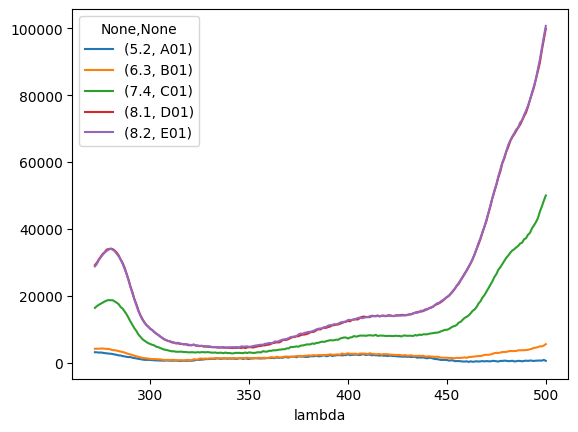

In [23]:
tit0.plot()

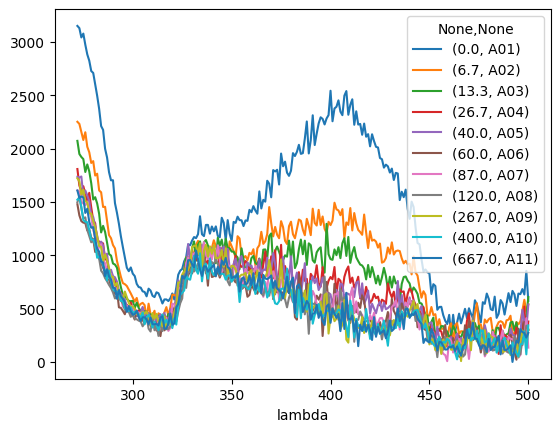

In [24]:
tit1.plot()

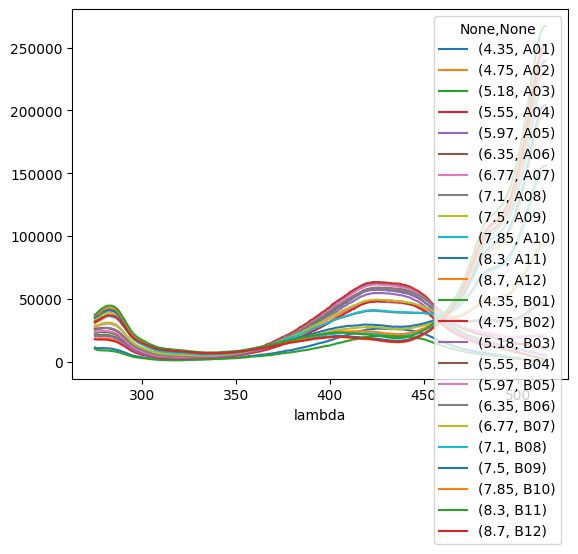

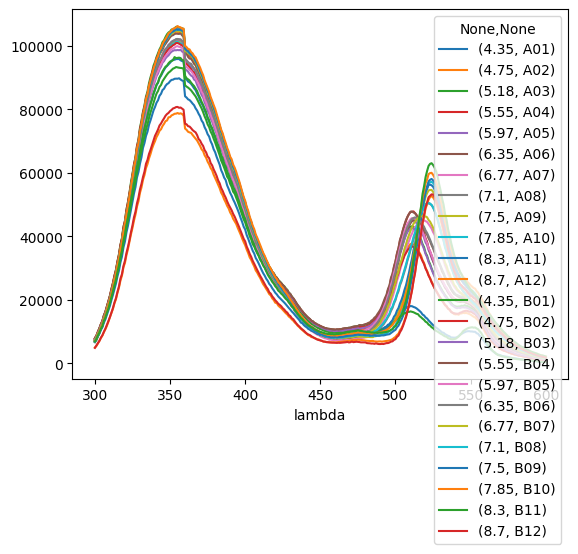

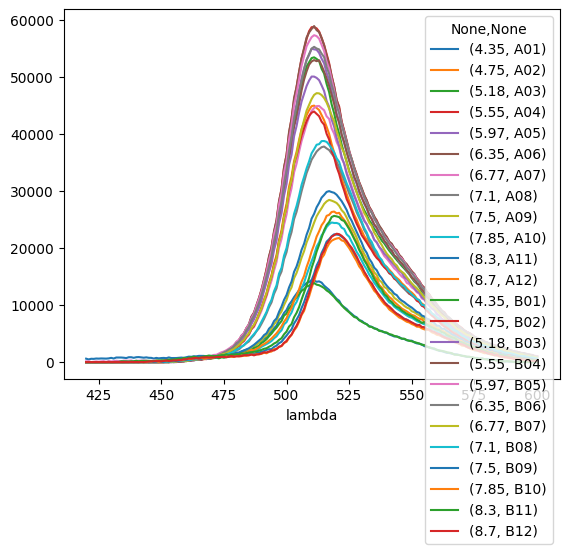

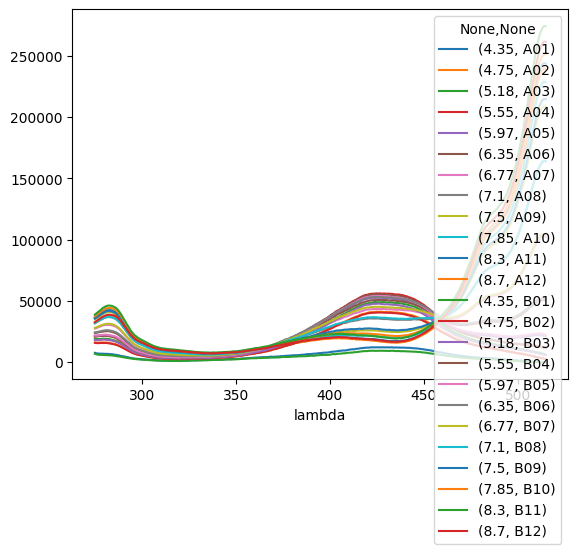

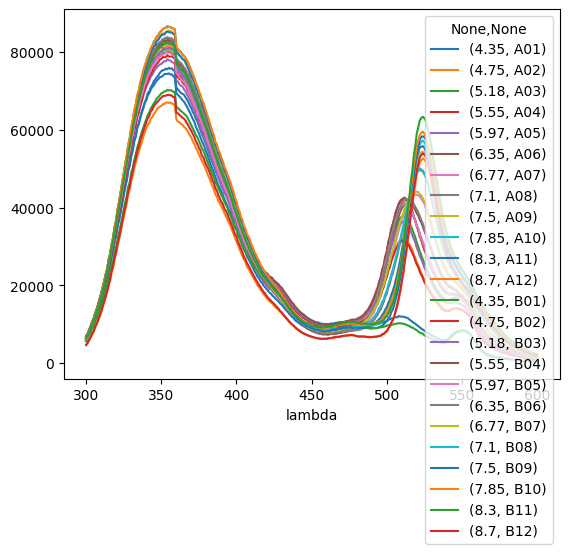

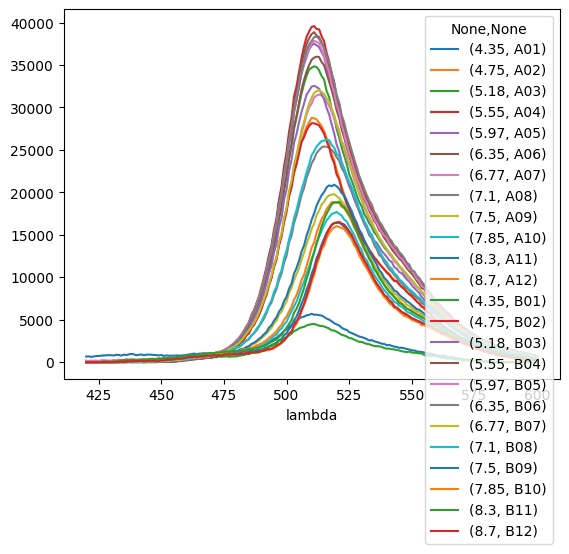

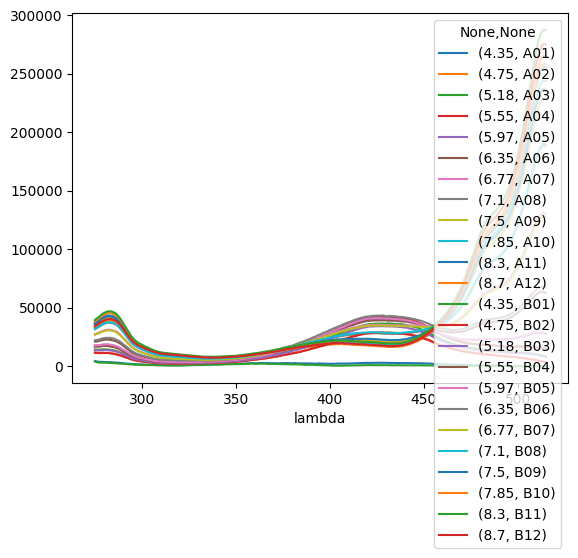

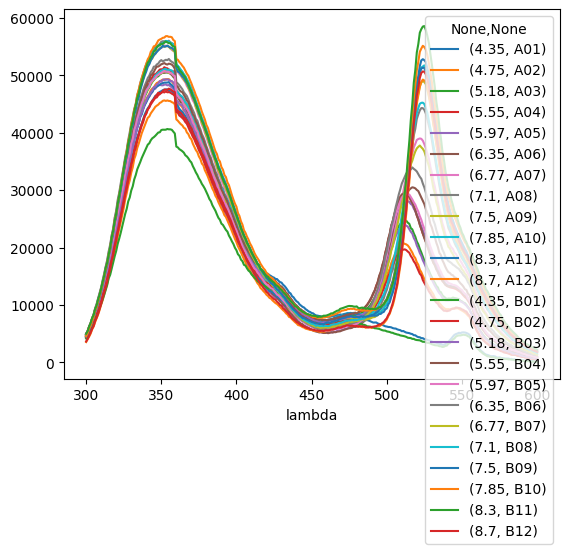

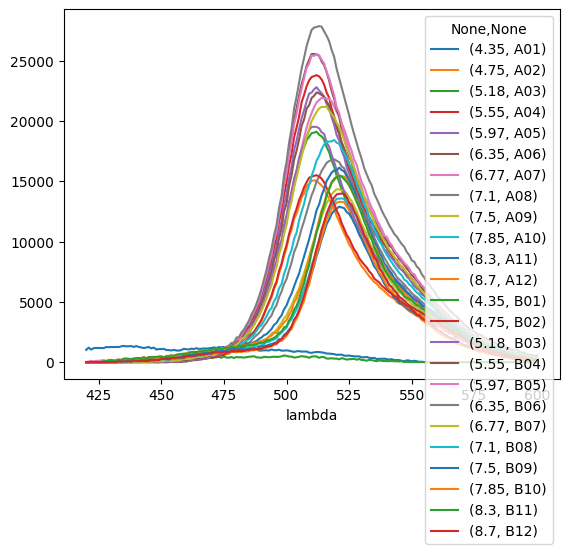

In [26]:
en3.build_titrations(efx3)
en3.titrations[0].plot()